# Figure 2
Assumes all data is in ../../data

# Setup and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use FixedLocator along with FixedFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression


from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    colors_for_sequence,
    format_small_plot,
)

In [3]:
DATA_PATH = "../../data/"

In [4]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df = df.query("r_type == 'Flank-WC' or r_type == 'NON-WC'").copy()
df["ln_r_data"] = np.log(df["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# for this figure we want to label all WC as WC
df["r_type_simple"] = df["r_type"].replace("Flank-WC", "WC")

# Plots

## Figure 2A: reactivity overlap between non-wc and wc

In [6]:
def plot_figure_2a(df, ax):
    ax = sns.violinplot(
        x="ln_r_data",
        y="r_type_simple",
        data=df,
        hue="r_type_simple",
        order=["WC", "NON-WC"],
        ax=ax,
        linewidth=0.5,
    )
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Nucleotide Type", labelpad=2)
    ax.yaxis.set_major_locator(FixedLocator([0, 1, 2]))
    ax.yaxis.set_major_formatter(FixedFormatter(["WC", "Non-\nWC"]))
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

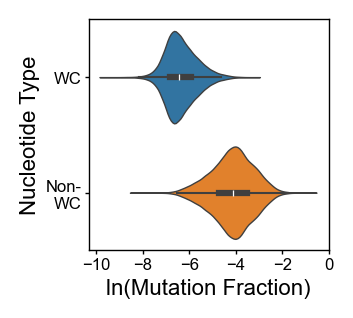

In [7]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2a(df, ax)
plt.savefig("pngs/figure_2a.png", dpi=600)

## Figure 2B: reactivity cummulative distribution

In [8]:
def plot_figure_2b(df, ax):
    df.sort_values("r_type", inplace=True, ascending=True)
    colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
    # Loop through each unique r_type to plot the cumulative distribution
    for r_type, group_data in df.groupby("r_type_simple"):
        sorted_data = np.sort(group_data["ln_r_data"])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
        ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
    ax.set_ylabel("Cumulative Dist. (%)", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

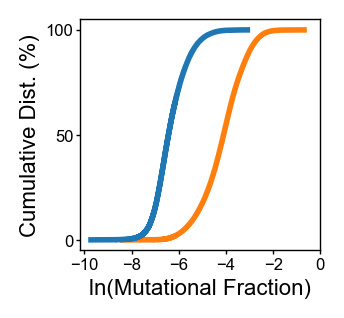

In [9]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2b(df, ax)
plt.savefig("pngs/figure_2b.png", dpi=600)

## Figure 2C: Logistic regression of WC vs non-WC

In [10]:
df["ln_r_data"].replace(-np.inf, -10, inplace=True)
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090406
std           1.367130
min         -10.000000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [11]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df["r_type_binary"] = df["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[["ln_r_data"]], df["r_type_binary"])
# Compute probabilities for the original data
df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
# Display the probabilities
df.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type_simple", "prob_WC"]]
# df.to_csv("Prob.csv", index=False)

,ln_r_data,r_type_simple,prob_WC
9080,-10.000000,WC,0.999998
66453,-10.000000,WC,0.999998
186005,-10.000000,WC,0.999998
308860,-10.000000,WC,0.999998
185577,-10.000000,WC,0.999998
...,...,...,...
463233,-1.013022,NON-WC,0.000003
463209,-0.994414,NON-WC,0.000003
105290,-0.972755,NON-WC,0.000003
105296,-0.853363,NON-WC,0.000002


In [12]:
def plot_figure_2c(df, ax):
    ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
    ax.set_ylabel("Probability of WC pair", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.axhline(y=0.5, color="black", linestyle="--", lw=0.75)
    ax.axvline(x=-5.45, color="black", linestyle="--", lw=0.75)
    format_small_plot(ax)
    return ax

In [13]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df["abs_diff"] = (df["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.453802269388432


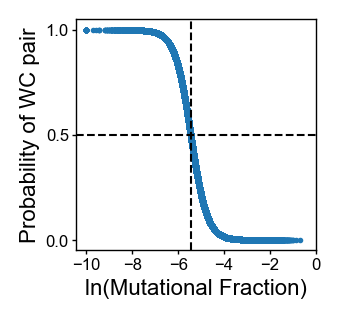

In [14]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2c(df, ax)
plt.savefig("pngs/figure_2c.png", dpi=600)

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Count (×10³)'>

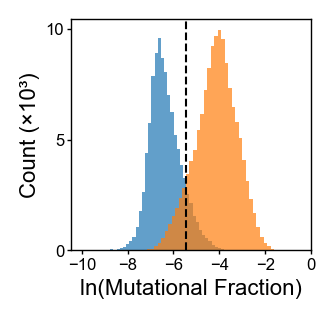

In [15]:
def plot_figure_2d(df, ax, threshold=-5.45):

    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'Flank-WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )

    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)

    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.set_yticks([0, 5000, 10000], labels=["0", "5", "10"])
    format_small_plot(ax)
    return ax


# Create and save plot
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2d(df, ax)

In [16]:
percent_non_wc = len(df.query("ln_r_data < -5.45 and r_type == 'NON-WC'")) / len(
    df.query("r_type == 'NON-WC'")
)
print(f"% of non-WC below 0.5 probability cutoff: {percent_non_wc}")
percent_wc = len(df.query("ln_r_data > -5.45 and r_type == 'Flank-WC'")) / len(
    df.query("r_type == 'Flank-WC'")
)
print(f"% of WC above 0.5 probability cutoff: {percent_wc}")

% of non-WC below 0.5 probability cutoff: 0.0888439922124674
% of WC above 0.5 probability cutoff: 0.10708686263102364


## Combined Figure 2A-C


Subplot 1 dimensions: 1.23" wide x 1.23" tall
Subplot 2 dimensions: 1.23" wide x 1.23" tall
Subplot 3 dimensions: 1.23" wide x 1.23" tall
Subplot 4 dimensions: 1.23" wide x 1.23" tall


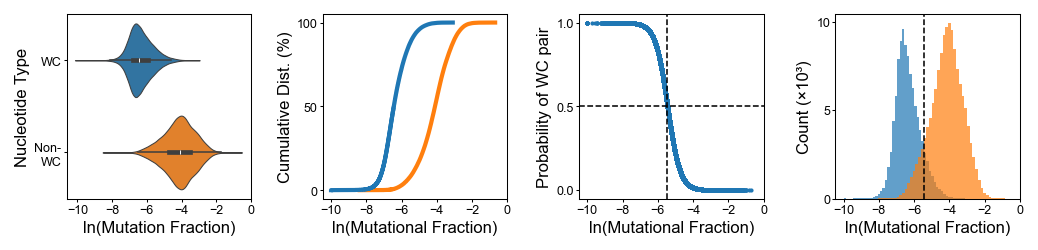

In [50]:
# Create figure with overall size
fig = plt.figure(figsize=(7.00, 1.75), dpi=150)

# Create GridSpec with equal width ratios and spacing between subplots
gs = gridspec.GridSpec(1, 4, figure=fig)

# Add subplots with specified sizes and make them square
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

# Plot figures
plot_figure_2a(df, ax1)
plot_figure_2b(df, ax2)
plot_figure_2c(df, ax3)
plot_figure_2d(df, ax4)

# Adjust layout to prevent overlapping
gs.tight_layout(fig, pad=1.0, w_pad=1.10)

# Get and print subplot dimensions after tight_layout
for i, ax in enumerate([ax1, ax2, ax3, ax4], 1):
    bbox = ax.get_position()
    width = bbox.width * fig.get_figwidth()
    height = bbox.height * fig.get_figheight()
    print(f'Subplot {i} dimensions: {width:.2f}" wide x {height:.2f}" tall')

# Save figure
plt.savefig("pngs/figure_2.png", dpi=600, bbox_inches="tight", pad_inches=0.02)